# Customer Churn

# OBJECTIVE

1. Customer Churn & Retention Analysis
2. Customer Churn Categorization
3. Customer Churn prediction for customer that have 1 transaction of all time

# IMPORT PACKAGE

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.tseries.offsets import DateOffset
import datetime

## OVERSAMPLING
from imblearn.over_sampling import SMOTENC

## SCALLING
from sklearn.preprocessing import StandardScaler, RobustScaler, PolynomialFeatures, MinMaxScaler, OneHotEncoder

## MODEL
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, train_test_split
import xgboost as xgb

## METRIC
from sklearn.metrics import recall_score, precision_score, accuracy_score, confusion_matrix, classification_report

# CALLING DATASET

In [2]:
path_dataset = "../phillip morris case code/retail_transaction_data.csv"
df = pd.read_csv(path_dataset)
df.head()

,order_id,product_id,product_description,quantity,order_date,unit_price,customer_id,country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


# DATA QUALITY CHECK

## DATA TYPE

In [3]:
## DATATYPE CHECK
df.dtypes

order_id                object
product_id              object
product_description     object
quantity                 int64
order_date              object
unit_price             float64
customer_id            float64
country                 object
dtype: object

In [4]:
## CHANGE DATATYPE
### customer_id --> string
### order_date --> Timestamp

df['customer_id'] = df['customer_id'].astype(str)
df['order_date'] = pd.to_datetime(df['order_date'])
df['customer_id'] = np.where(df['customer_id']=='nan', np.nan, df['customer_id'])

In [5]:
df.dtypes

order_id                       object
product_id                     object
product_description            object
quantity                        int64
order_date             datetime64[ns]
unit_price                    float64
customer_id                    object
country                        object
dtype: object

## NULL VALUES

In [6]:
df.isnull().sum()

order_id                    0
product_id                  0
product_description      4382
quantity                    0
order_date                  0
unit_price                  0
customer_id            243007
country                     0
dtype: int64

In [7]:
df[df['customer_id'].isnull()]

,order_id,product_id,product_description,quantity,order_date,unit_price,customer_id,country
263,489464,21733,85123a mixed,-96,2009-12-01 10:52:00,0.00,NaN,United Kingdom
283,489463,71477,short,-240,2009-12-01 10:52:00,0.00,NaN,United Kingdom
284,489467,85123A,21733 mixed,-192,2009-12-01 10:53:00,0.00,NaN,United Kingdom
470,489521,21646,NaN,-50,2009-12-01 11:44:00,0.00,NaN,United Kingdom
577,489525,85226C,BLUE PULL BACK RACING CAR,1,2009-12-01 11:49:00,0.55,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
1066997,581498,85099B,JUMBO BAG RED RETROSPOT,5,2011-12-09 10:26:00,4.13,NaN,United Kingdom
1066998,581498,85099C,JUMBO BAG BAROQUE BLACK WHITE,4,2011-12-09 10:26:00,4.13,NaN,United Kingdom
1066999,581498,85150,LADIES & GENTLEMEN METAL SIGN,1,2011-12-09 10:26:00,4.96,NaN,United Kingdom
1067000,581498,85174,S/4 CACTI CANDLES,1,2011-12-09 10:26:00,10.79,NaN,United Kingdom


In [8]:
# aaa

## DATA DESCRIBE

In [9]:
df.describe()

,quantity,order_date,unit_price
count,1.067371e+06,1067371,1.067371e+06
mean,9.938898e+00,2011-01-02 21:13:55.394028544,4.649388e+00
min,-8.099500e+04,2009-12-01 07:45:00,-5.359436e+04
25%,1.000000e+00,2010-07-09 09:46:00,1.250000e+00
50%,3.000000e+00,2010-12-07 15:28:00,2.100000e+00
75%,1.000000e+01,2011-07-22 10:23:00,4.150000e+00
max,8.099500e+04,2011-12-09 12:50:00,3.897000e+04
std,1.727058e+02,NaN,1.235531e+02


Quantity & unit_price have < 0 value

## ORDER CANCEL

In [10]:
df['order_status'] = np.where(df['order_id'].str.startswith('C'), 'CANCEL', 'SALE')

In [11]:
df_os = df.groupby('order_status').agg({'order_id':'nunique'}).reset_index()
df_os['%'] = (df_os['order_id']/df_os['order_id'].sum())*100
df_os

,order_status,order_id,%
0,CANCEL,8292,15.462072
1,SALE,45336,84.537928


# DATASET PREPARATION

- FILTERING
  - exclude order cancel (focused on transaction that generated value)
  - exclude quantity =< 0
  - exclude unit_price =< 0
- ADD COLUMNS
  - Revenue = `quantity` * `unit_price`
  - year_order = Truncate Year of `order_date`
  - year_quarter_order = Truncate Year & Quarter of `order_date`
  - year_month_order = Truncate Year & month `order_date`

In [12]:
## FILTER
df = df[df['order_status'] == 'SALE']
df = df[df['quantity'] > 0]
df = df[df['unit_price'] > 0]

In [13]:
## ENRICHMENT COLUMNT DATA TRANSACTION
df['revenue'] = df['quantity'] * df['unit_price']
df['year_order'] = df['order_date'].dt.year
df['month_order'] = df['order_date'].dt.month
df['year_quarter_order'] = df['order_date'].dt.to_period('Q').dt.to_timestamp()
df['year_month_order'] = df['order_date'].dt.to_period('M').dt.to_timestamp()
df['order_date_day'] = df['order_date'].dt.to_period('D').dt.to_timestamp()
df['quarter'] = pd.PeriodIndex(df['order_date'], freq='Q').astype('str')
df.head()

## DAILY DATA
df_daily = df.groupby([
                        'order_id', 'order_date_day', 'year_month_order'
                        , 'customer_id']).agg(
                        {'quantity':'sum', 'revenue':'sum'}).reset_index()
df_daily['rank_order'] = df_daily.sort_values('order_date_day', ascending=True).groupby('customer_id').cumcount()+1
df_daily['rank_order_prev'] = df_daily['rank_order'] - 1
df_daily = pd.merge(
                    df_daily
                    , df_daily[['rank_order', 'order_id', 'customer_id', 'order_date_day']]
                    , how = 'left'
                    , left_on = ['rank_order_prev', 'customer_id']
                    , right_on = ['rank_order', 'customer_id']
            ).drop(columns=['rank_order_prev', 'rank_order_y']).rename(columns={
                'order_id_y':'prev_order_id'
                ,'order_date_day_y' : 'prev_order_date_day'
                , 'order_id_x' : 'order_id'
                , 'order_date_day_x' : 'order_date_day'
                , 'rank_order_x' : 'rank_order'
            })
df_daily['days_between_order'] = (df_daily['order_date_day'] - df_daily['prev_order_date_day']).dt.days

## CHURN CATEGORIZATION
df_churn_cat_raw = df_daily[df_daily['rank_order']>1]

df_cat_churn = df_churn_cat_raw.groupby('customer_id').agg({'days_between_order':'mean'}).reset_index()
df_cat_churn['churn_cat'] = np.where(df_cat_churn['days_between_order'] <= 50, 'Non Churn Customer', 'Churn Customer')

df_churn = pd.merge(df, df_cat_churn, how='left', on='customer_id').drop(columns=['days_between_order'])
df_churn['churn_cat'] = df_churn['churn_cat'].fillna('One Time Order')

In [14]:
df_churn.head()

,order_id,product_id,product_description,quantity,order_date,unit_price,customer_id,country,order_status,revenue,year_order,month_order,year_quarter_order,year_month_order,order_date_day,quarter,churn_cat
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,SALE,83.4,2009,12,2009-10-01,2009-12-01,2009-12-01,2009Q4,Churn Customer
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,SALE,81.0,2009,12,2009-10-01,2009-12-01,2009-12-01,2009Q4,Churn Customer
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,SALE,81.0,2009,12,2009-10-01,2009-12-01,2009-12-01,2009Q4,Churn Customer
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,SALE,100.8,2009,12,2009-10-01,2009-12-01,2009-12-01,2009Q4,Churn Customer
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,SALE,30.0,2009,12,2009-10-01,2009-12-01,2009-12-01,2009Q4,Churn Customer


__GRANULARIY__ : 
- customer_id

__COLUMNS NEED FOR MODELLING__: 
1. customer_id
2. country_big : country per customer that contribute the most quantity
3. product_big : product per customer that contribute the most quantity
4. total_revenue
5. total_quantity
6. Order_frequency
7. churn_category

In [15]:
## FIND THE PRODUCT THAT HAVE THE BIGGEST QUANTITY PER CUSTOMER

df_cust_p = df_churn.groupby(['customer_id', 'product_id']).agg({'quantity' : 'sum'}).reset_index()
df_cust_p['rank_p'] = df_cust_p.sort_values('quantity', ascending=False).groupby('customer_id').cumcount()+1
df_cust_p = df_cust_p[df_cust_p['rank_p']==1].rename(columns={'product_id' : 'product_id_big'})

## FIND THE COUNTRY THAT HAVE THE BIGGEST QUANTITY PER CUSTOMER

df_cust_c = df_churn.groupby(['customer_id', 'country']).agg({'quantity' : 'sum'}).reset_index()
df_cust_c['rank_c'] = df_cust_c.sort_values('quantity', ascending=False).groupby('customer_id').cumcount()+1
df_cust_c = df_cust_c[df_cust_c['rank_c']==1].rename(columns={'country' : 'country_big'})

## FIND THE PRODUCT THAT HAVE THE BIGGEST FREQ PER CUSTOMER

df_cust_p_freq = df_churn.groupby(['customer_id', 'product_id']).agg({'order_id' : 'nunique'}).reset_index()
df_cust_p_freq['rank_freq_p'] = df_cust_p_freq.sort_values('order_id', ascending=False).groupby('customer_id').cumcount()+1
df_cust_p_freq = df_cust_p_freq[df_cust_p_freq['rank_freq_p']==1].rename(columns={'product_id' : 'product_id_high_freq'})

## FIND THE COUNTRY THAT HAVE THE BIGGEST QUANTITY PER CUSTOMER

df_cust_c_freq = df_churn.groupby(['customer_id', 'country']).agg({'order_id' : 'nunique'}).reset_index()
df_cust_c_freq['rank_freq_c'] = df_cust_c_freq.sort_values('order_id', ascending=False).groupby('customer_id').cumcount()+1
df_cust_c_freq = df_cust_c_freq[df_cust_c_freq['rank_freq_c']==1].rename(columns={'country' : 'country_high_freq'})

In [16]:
## DAILY DATA TRANSACTION PER ORDER & CUSTOMER & PRODUCT_ID & COUNTRY
df_churn_daily_pc = df_churn.groupby([
                        'order_id', 'customer_id', 'product_id', 'country']).agg(
                        {'quantity':'sum'}).reset_index()
df_churn_daily_pc['rank_pc'] = df_churn_daily_pc.sort_values('quantity', ascending=False)\
                                .groupby(['order_id', 'customer_id']).cumcount()+1
df_churn_daily_pc_bigq = df_churn_daily_pc[df_churn_daily_pc['rank_pc'] == 1] 

## DAILY DATA TRANSACTION PER ORDER & CUSTOMER
df_churn_daily = df_churn.groupby([
                        'order_id', 'customer_id', 'order_date_day', 'churn_cat']).agg(
                        {'quantity':'sum', 'revenue':'sum', 'unit_price':'mean'}).reset_index()
df_churn_daily['rank_order'] = df_churn_daily.sort_values('order_date_day', ascending=True)\
                                .groupby('customer_id').cumcount()+1

df_churn_daily_agg_cust = df_churn_daily.groupby('customer_id')\
                        .agg({'order_id':'nunique'})\
                        .rename(columns={'order_id':'n_order_per_cust'}).reset_index()

df_churn_daily = pd.merge(df_churn_daily, df_churn_daily_agg_cust, how='left', on='customer_id')
df_churn_daily = pd.merge(df_churn_daily, df_churn_daily_pc_bigq, how='left', on=['order_id'
                                                                                  , 'customer_id'])\
                    .drop(columns=['quantity_y', 'rank_pc'])\
                    .rename(columns={'quantity_x':'quantity', 'product_id':'big_product_id'
                                     , 'country':'big_country'})
df_churn_daily['year_order'] = df_churn_daily['order_date_day'].dt.year.astype('str')
df_churn_daily['quarter_order'] = df_churn_daily['order_date_day'].dt.quarter.astype('str')
df_churn_daily['month_order'] = df_churn_daily['order_date_day'].dt.month.astype('str')
df_churn_daily['day_order'] = df_churn_daily['order_date_day'].dt.day.astype('str')
df_churn_daily['season'] = np.where(df_churn_daily['month_order'].astype('str').isin(['12','1', '2']), 'Winter', 
                           np.where(df_churn_daily['month_order'].astype('str').isin(['3','4', '5']), 'Spring', 
                            np.where(df_churn_daily['month_order'].astype('str').isin(['6','7', '8']), 'Summer', 'Fall')))

## GET LAST PRODUCT & COUNTRY PER CUSTOMER

df_cust_last_pc = df_churn_daily[df_churn_daily['rank_order']==df_churn_daily['n_order_per_cust']]\
                    [['customer_id','big_product_id', 'big_country']].rename(columns={
                        'big_product_id' : 'last_product_id'
                        , 'big_country' : 'last_country'
                    })

df_cust_last_pc.head()


## JOIN ALL
df_churn_daily_final = pd.merge(
    pd.merge(df_churn_daily, df_cust_p[['customer_id', 'product_id_big']], how='left', on='customer_id')
    , df_cust_c[['customer_id', 'country_big']]
    , how='left'
    , on='customer_id'
)

df_churn_daily_final = pd.merge(
    pd.merge(df_churn_daily_final, df_cust_p_freq[['customer_id', 'product_id_high_freq']], how='left', on='customer_id')
    , df_cust_c_freq[['customer_id', 'country_high_freq']]
    , how='left'
    , on='customer_id'
)

df_churn_daily_final = pd.merge(
    df_churn_daily_final
    , df_cust_last_pc[['customer_id', 'last_product_id', 'last_country']]
    , how='left'
    , on='customer_id'
)

## DATA CHURN AGG PER CUSTOMER
### SUMMARIZE METRIC

df_cust_churn = df_churn_daily_final.groupby(['customer_id', 'country_big', 'product_id_big', 'churn_cat']).agg({
    'quantity' : 'sum'
    , 'revenue' : 'sum'
    , 'order_id' : 'nunique'
}).reset_index().rename(columns={
    'quantity' : 'total_quantity'
    , 'revenue' : 'total_revenue'
    , 'order_id' : 'order_freq'
    , 'churn_cat' : 'churn_category'
})

In [17]:
df_cust_churn.head()
# aaa

,customer_id,country_big,product_id_big,churn_category,total_quantity,total_revenue,order_freq
0,12346.0,United Kingdom,23166,Non Churn Customer,74285,77556.46,12
1,12347.0,Iceland,23076,Churn Customer,3286,5633.32,8
2,12348.0,Finland,23077,Churn Customer,2714,2019.40,5
3,12349.0,Italy,21232,Churn Customer,1624,4428.69,4
4,12350.0,Norway,22348,One Time Order,197,334.40,1


# DATASET MODEL CLASSIFICATION PREPARATION

__Drop Column customer_id from dataset per customer (df_cust_churn)__

__DATA FOR MODELLING__
1. Only customer that have total order > 1 of all time

In [18]:
df_cust_churn['churn_category'].unique()

array(['Non Churn Customer', 'Churn Customer', 'One Time Order'],
      dtype=object)

In [19]:
df_model = df_cust_churn[df_cust_churn['churn_category']!= 'One Time Order'].drop(columns='customer_id')

df_model.head()

,country_big,product_id_big,churn_category,total_quantity,total_revenue,order_freq
0,United Kingdom,23166,Non Churn Customer,74285,77556.46,12
1,Iceland,23076,Churn Customer,3286,5633.32,8
2,Finland,23077,Churn Customer,2714,2019.40,5
3,Italy,21232,Churn Customer,1624,4428.69,4
6,Norway,84050,Non Churn Customer,724,2849.84,10


# MODELLING

## TRAIN TEST SPLIT

In [20]:
df_model['churn_category'].unique()

array(['Non Churn Customer', 'Churn Customer'], dtype=object)

In [21]:
# change target column values to numeric value

df_model['churn_category'] = np.where(df_model['churn_category'] == 'Non Churn Customer', 0, 1)
df_model.head()

,country_big,product_id_big,churn_category,total_quantity,total_revenue,order_freq
0,United Kingdom,23166,0,74285,77556.46,12
1,Iceland,23076,1,3286,5633.32,8
2,Finland,23077,1,2714,2019.40,5
3,Italy,21232,1,1624,4428.69,4
6,Norway,84050,0,724,2849.84,10


In [22]:
# seperate the columns into X and Y

X = df_model.drop(columns='churn_category')
y = df_model['churn_category']

In [23]:
# data splitting

x_train, x_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.20, random_state=42)

## CHECK IMBALANCE DATA & OVER SAMPLING

If imbalance, than use SMOTE Oversampling method

here's the figure of SMOTE Oversampling to give some prespective

![SMOTE](https://miro.medium.com/v2/resize:fit:1400/0*MaZhmNw4iqK4M086.png)

In [24]:
df_train = pd.concat([x_train,y_train], axis=1)
df_train.head()

,country_big,product_id_big,total_quantity,total_revenue,order_freq,churn_category
5233,United Kingdom,84818,280,547.06,2,1
2892,United Kingdom,21181,428,961.90,3,1
1566,United Kingdom,84598,3488,5257.38,11,1
5433,United Kingdom,20668,37558,70884.07,211,0
4400,United Kingdom,21845,898,1545.62,6,0


In [25]:
# check data imbalance in df_train

round(df_train['churn_category'].value_counts()/len(df_train)*100, 2)

churn_category
1    66.01
0    33.99
Name: count, dtype: float64

__IMBALANCE!__

In [26]:
x_train.dtypes

country_big        object
product_id_big     object
total_quantity      int64
total_revenue     float64
order_freq          int64
dtype: object

In [27]:
num_columns = list(x_train.select_dtypes(include=['int', 'float']).columns)
cat_columns = [i for i in list(x_train.columns) if i not in num_columns]

idx_cat_columns = [list(x_train.columns).index(i) for i in cat_columns]

In [28]:
#SMOTE OVER SAMPLING
sm_cat = SMOTENC(random_state=42, categorical_features=idx_cat_columns)
x_sm, y_sm = sm_cat.fit_resample(x_train, y_train)

In [29]:
# Check Balance of target field
y_sm.value_counts()

churn_category
1    2247
0    2247
Name: count, dtype: int64

In [30]:
print(num_columns)
print(cat_columns)

['total_quantity', 'total_revenue', 'order_freq']
['country_big', 'product_id_big']


__BALANCE !__

## CHECK INCLUSIVITY

In [31]:
df_sm = pd.concat([x_sm,y_sm], axis=1)
df_test = pd.concat([x_test,y_test], axis=1)

In [32]:
def cek_inclusivity(train, test, col_product, col_country) : 
    train_copy = train.copy()
    test_copy = test.copy()
    
    train_copy['product_country_train'] = train_copy[[col_product,col_country]].agg('-'.join, axis=1)
    test_copy['product_country_test'] = test_copy[[col_product,col_country]].agg('-'.join, axis=1)

    cek = pd.merge(
        train_copy[['product_country_train']].drop_duplicates()
        , test_copy[['product_country_test']].drop_duplicates()
        , how = 'outer'
        , left_on = 'product_country_train'
        , right_on = 'product_country_test'
        )
    cek['category'] = np.where(cek['product_country_train'].isnull(), 'TEST DATA NOT IN TRAIN'
                    , np.where(cek['product_country_test'].isnull(), 'TRAIN DATA NOT IN TEST', 'DATA IN TEST & TRAIN'))
    cek['n'] = 1

    return cek

def cek_inclusivity_chart (data) : 
    cek_agg = data.groupby('category').agg({'n':'sum'}).reset_index()

    plt.pie(cek_agg['n'], labels=cek_agg['category'], autopct='%1.1f%%')
    plt.show()

    return display(cek_agg)

## FUNCTION CLEANING DATA TEST
def data_test (data_test_raw, col_product, col_country, list_test_not_in_train) : 
    data_test_raw['product_country'] = data_test_raw[[col_product,col_country]].agg('-'.join, axis=1)

    return data_test_raw[~data_test_raw['product_country'].isin(list_test_not_in_train)].drop(columns='product_country')

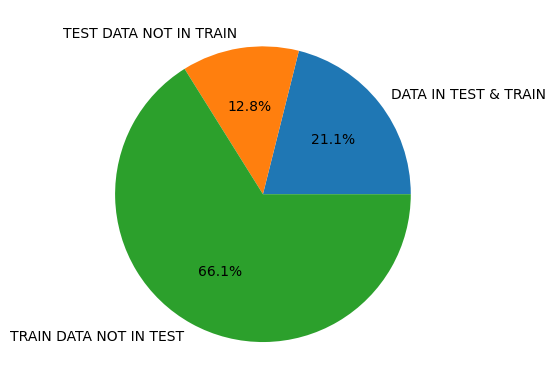

,category,n
0,DATA IN TEST & TRAIN,275
1,TEST DATA NOT IN TRAIN,167
2,TRAIN DATA NOT IN TEST,862


In [33]:
cek_inclusivity_chart(cek_inclusivity(df_sm, df_test, 'product_id_big', 'country_big'))

In [34]:
df_test.shape

(851, 6)

In [35]:
cek = cek_inclusivity(df_sm, df_test, 'product_id_big', 'country_big')
list_data_test_not_in_train = list(cek[cek['category']=='TEST DATA NOT IN TRAIN']['product_country_test'])

data_test_std = data_test(df_test, 'product_id_big', 'country_big', list_data_test_not_in_train)
x_test_std = data_test_std.drop(columns='churn_category')
y_test_std = data_test_std['churn_category']

## CREATE PIPELINE MODEL FUNCTION

1. Numerical columns : use robust scaller
2. Categorical columsn : use one hot encoder (except for XGBoost model, use params

__XGB__ : 

In [36]:
numeric_pipeline = Pipeline([
    ('scaler', RobustScaler())
    # ('preprocessor', PolynomialFeatures(degree=2, include_bias=False))
])

categoric_pipeline = Pipeline([
    ('encoder', OneHotEncoder())
])

preprocessor_numeric = ColumnTransformer([
    ('numeric', numeric_pipeline, num_columns)
])

preprocessor_all = ColumnTransformer([
    ('numeric', numeric_pipeline, num_columns),
    ('categorical', categoric_pipeline, cat_columns)
])

pipe_LR = Pipeline([
    ('prep', preprocessor_all),
    ('algo', LogisticRegression(max_iter=1100))
])

pipe_XGB = Pipeline([
    ('prep', preprocessor_numeric),
    ('algo', XGBClassifier(
        enable_categorical=True
        , learning_rate=0.5
        , objective='binary:logistic'
    ))
])

pipe_DT = Pipeline([
    ('prep', preprocessor_all),
    ('algo', DecisionTreeClassifier(random_state=42))
])

## CREATE FUNCTION EVALUATION MATRIX FOR MODELS

In [37]:
# def function for each model evaluation matrix

def conf_mat (Model, X_train, X_test, y_train, y_test,Nama):
    y_pred_test = Model.predict(X_test)
    cm_test = confusion_matrix(y_test, y_pred_test, labels=[1,0])
    df_test = pd.DataFrame(cm_test, index = ['Akt1', 'Akt0'], columns=['Pred1', 'Pred0'])
    print( 'Classification report data TEST ' + Nama + '\n\n', classification_report(y_test, y_pred_test))
    print('\nConfusion matrix data test ' + Nama + '\n\n')
    print(df_test)
    print('='*100)
    y_pred_train = Model.predict(X_train)
    cm_train = confusion_matrix(y_train, y_pred_train, labels=[1,0])
    df_train = pd.DataFrame(cm_train, index = ['Akt1', 'Akt0'], columns=['Pred1', 'Pred0'])
    print( 'Classification report data TRAIN ' + Nama + '\n\n', classification_report(y_train, y_pred_train))
    print('\nConfusion matrix data train ' + Nama + '\n\n')
    print(df_train)

In [38]:
# def function to compare the evaluation matrix for some models

def prec_rec (Model, X_test, y_test, Nama):
    data = {}
    prec = []
    rec = []
    acc = []
    for i in Model :
        y_pred_ts = i.predict(X_test)
        precision = precision_score(y_test, y_pred_ts, average="macro")
        recall = recall_score(y_test, y_pred_ts, average="macro")
        accuracy = accuracy_score(y_test, y_pred_ts)
        prec.append(precision)
        rec.append(recall)
        acc.append(accuracy)
    for j in range (len(Nama)):
        data[Nama[j]] = [prec[j], rec[j], acc[j]]

    df = pd.DataFrame(data, index=['Precison', 'Recall', 'Accuracy'])
    return df

## START MODELLING

### XGB

- 

In [39]:
model_XGB = pipe_XGB.fit(x_sm, y_sm)

In [40]:
# evaluation matrix XGB
conf_mat(model_XGB, x_sm, x_test, y_sm, y_test, 'XGB Base')

Classification report data TEST XGB Base

               precision    recall  f1-score   support

           0       0.51      0.52      0.51       289
           1       0.75      0.75      0.75       562

    accuracy                           0.67       851
   macro avg       0.63      0.63      0.63       851
weighted avg       0.67      0.67      0.67       851


Confusion matrix data test XGB Base


      Pred1  Pred0
Akt1    421    141
Akt0    140    149
Classification report data TRAIN XGB Base

               precision    recall  f1-score   support

           0       0.94      0.88      0.91      2247
           1       0.88      0.94      0.91      2247

    accuracy                           0.91      4494
   macro avg       0.91      0.91      0.91      4494
weighted avg       0.91      0.91      0.91      4494


Confusion matrix data train XGB Base


      Pred1  Pred0
Akt1   2118    129
Akt0    278   1969


### Logistic Regression

Data test use the standarize (combination product & country is in train data)

In [41]:
model_LR = pipe_LR.fit(x_sm, y_sm)

In [42]:
# evaluation matrix LR
conf_mat(model_LR, x_sm, x_test_std, y_sm, y_test_std, 'LR Base')

Classification report data TEST LR Base

               precision    recall  f1-score   support

           0       0.53      0.50      0.51       228
           1       0.75      0.77      0.76       444

    accuracy                           0.68       672
   macro avg       0.64      0.64      0.64       672
weighted avg       0.67      0.68      0.68       672


Confusion matrix data test LR Base


      Pred1  Pred0
Akt1    342    102
Akt0    114    114
Classification report data TRAIN LR Base

               precision    recall  f1-score   support

           0       0.81      0.70      0.75      2247
           1       0.74      0.83      0.78      2247

    accuracy                           0.77      4494
   macro avg       0.77      0.77      0.77      4494
weighted avg       0.77      0.77      0.77      4494


Confusion matrix data train LR Base


      Pred1  Pred0
Akt1   1868    379
Akt0    667   1580


### Decision Tree

In [43]:
model_DT = pipe_DT.fit(x_sm, y_sm)

In [44]:
# evaluation matrix DT
conf_mat(model_DT, x_sm, x_test_std, y_sm, y_test_std, 'DT Base')

Classification report data TEST DT Base

               precision    recall  f1-score   support

           0       0.50      0.54      0.52       228
           1       0.75      0.72      0.74       444

    accuracy                           0.66       672
   macro avg       0.63      0.63      0.63       672
weighted avg       0.67      0.66      0.66       672


Confusion matrix data test DT Base


      Pred1  Pred0
Akt1    320    124
Akt0    104    124
Classification report data TRAIN DT Base

               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2247
           1       1.00      1.00      1.00      2247

    accuracy                           1.00      4494
   macro avg       1.00      1.00      1.00      4494
weighted avg       1.00      1.00      1.00      4494


Confusion matrix data train DT Base


      Pred1  Pred0
Akt1   2247      0
Akt0      0   2247


## CONCLUSION MODEL

- XGBoost, Logistic Regression & Decision Tree relatively have same Precision = 0.75, but the True Positive of XGBoost significantly higher (421 customers)
- XGBoost Model is better than other model to predict Churn Customer
- Also XGBoost can predict customers that have product & country that not in train data, not like Logistic Regression & DT that should exclude those data from data test
Chose XGBoost


## FEATURE IMPORTANCE

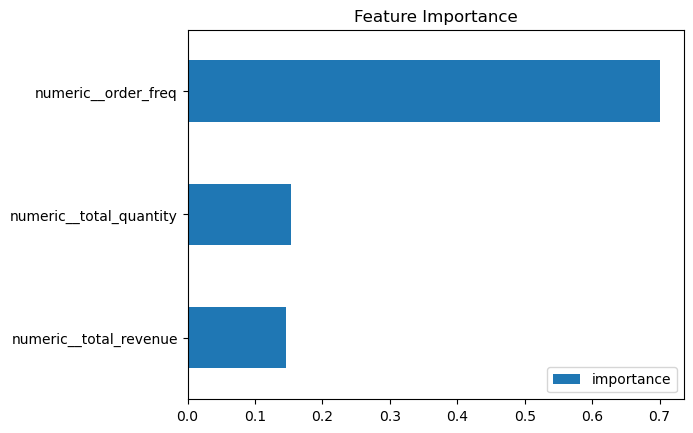

In [45]:
pd.DataFrame(
        data=model_XGB['algo'].feature_importances_
        , index=model_XGB[:-1].get_feature_names_out()
        , columns=['importance']
).sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

MIN : 2
MAX : 203
MEDIAN : 4.0
MEAN : 7.554641598119859


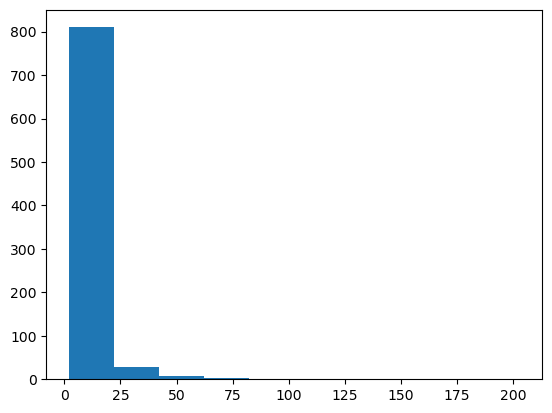

In [46]:
print('MIN : {}'.format(x_test['order_freq'].min()))
print('MAX : {}'.format(x_test['order_freq'].max()))
print('MEDIAN : {}'.format(x_test['order_freq'].median()))
print('MEAN : {}'.format(x_test['order_freq'].mean()))

plt.hist(x_test['order_freq'])
plt.show()

## PREDICT WITH ALL DATA

In [47]:
df_model.head()

,country_big,product_id_big,churn_category,total_quantity,total_revenue,order_freq
0,United Kingdom,23166,0,74285,77556.46,12
1,Iceland,23076,1,3286,5633.32,8
2,Finland,23077,1,2714,2019.40,5
3,Italy,21232,1,1624,4428.69,4
6,Norway,84050,0,724,2849.84,10


In [48]:
df_predict = df_cust_churn[df_cust_churn['churn_category']!= 'One Time Order']
df_predict['churn_category'] = np.where(df_predict['churn_category'] == 'Non Churn Customer', 0, 1)
df_predict['churn_prediction'] = model_XGB.predict(df_predict.drop(columns=['churn_category', 'customer_id']))
df_predict = df_predict.rename(columns={'churn_category':'churn_actual'})

df_predict.head()

/var/folders/hp/5n1_35ms0ygbmmvvvm6mq_3w0000gn/T/ipykernel_1503/19040818.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_predict['churn_category'] = np.where(df_predict['churn_category'] == 'Non Churn Customer', 0, 1)
/var/folders/hp/5n1_35ms0ygbmmvvvm6mq_3w0000gn/T/ipykernel_1503/19040818.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_predict['churn_prediction'] = model_XGB.predict(df_predict.drop(columns=['churn_category', 'customer_id']))


,customer_id,country_big,product_id_big,churn_actual,total_quantity,total_revenue,order_freq,churn_prediction
0,12346.0,United Kingdom,23166,0,74285,77556.46,12,0
1,12347.0,Iceland,23076,1,3286,5633.32,8,1
2,12348.0,Finland,23077,1,2714,2019.40,5,1
3,12349.0,Italy,21232,1,1624,4428.69,4,1
6,12352.0,Norway,84050,0,724,2849.84,10,0


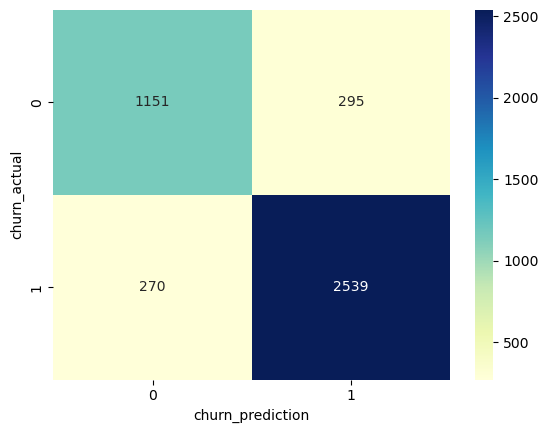

In [49]:
df_conf_matrix = df_predict.groupby(['churn_actual', 'churn_prediction']).count()[['order_freq']].reset_index().rename(columns={'order_freq':'n_cust'})
df_conf_matrix = df_conf_matrix.sort_values(['churn_actual', 'churn_prediction'], ascending=False)

sns.heatmap(
        df_conf_matrix.pivot(index='churn_actual', columns='churn_prediction', values='n_cust')
        ,annot=True, cmap='YlGnBu', fmt='g'
)

plt.show()

## STRATEGY RECOMMENDATION

MIN : 2
MAX : 15
MEDIAN : 4.0
MEAN : 5.0247000705716305


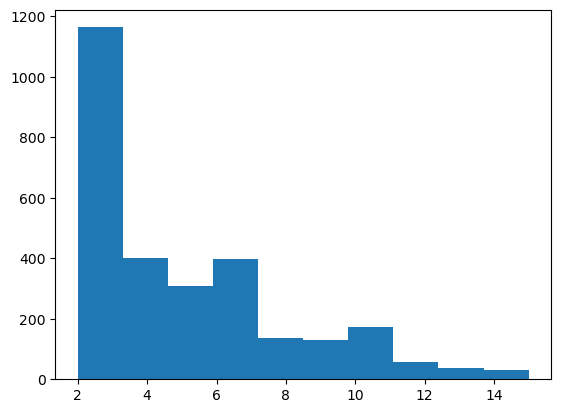

In [50]:
df_churn_pred = df_predict[df_predict['churn_prediction']==1]

print('MIN : {}'.format(df_churn_pred['order_freq'].min()))
print('MAX : {}'.format(df_churn_pred['order_freq'].max()))
print('MEDIAN : {}'.format(df_churn_pred['order_freq'].median()))
print('MEAN : {}'.format(df_churn_pred['order_freq'].mean()))
plt.hist(df_churn_pred['order_freq'])
plt.show()

In [51]:
df_churn_pred = pd.merge(
    pd.merge(df_churn_pred, df_cust_p_freq[['customer_id', 'product_id_high_freq']], how='left', on='customer_id')
    , df_cust_c_freq[['customer_id', 'country_high_freq']]
    , how='left'
    , on='customer_id'
)

df_churn_pred['campaign_urgency'] = np.where(df_churn_pred['order_freq'] >= 4, 'urgent', 'not urgent')

In [52]:
df_churn_pred.groupby(['campaign_urgency']).agg({'customer_id': 'nunique'}).rename(columns={'customer_id':'n_customer'}).sort_values('n_customer', ascending=False)

,n_customer
campaign_urgency,
urgent,1670
not urgent,1164


In [53]:
df_churn_pred_agg = df_churn_pred.groupby(['campaign_urgency', 'product_id_high_freq']).agg({'customer_id': 'nunique'}).reset_index()\
.rename(columns={'customer_id':'n_customer'}).sort_values('n_customer', ascending=False)

df_churn_pred_agg_2 = df_churn_pred.groupby(['campaign_urgency', 'product_id_high_freq'], as_index=False)['customer_id']\
.agg(lambda x: ', '.join(map(str, set(x))))

df_churn_pred_agg_all = pd.merge(df_churn_pred_agg, df_churn_pred_agg_2, how='left', on=['campaign_urgency','product_id_high_freq'])

df_churn_pred_agg_all.head(10)



,campaign_urgency,product_id_high_freq,n_customer,customer_id
0,urgent,85123A,109,"15774.0, 14942.0, 14047.0, 14173.0, 17827.0, 1..."
1,urgent,POST,84,"12449.0, 12664.0, 12728.0, 12421.0, 12670.0, 1..."
2,urgent,22423,46,"16621.0, 14463.0, 14626.0, 14853.0, 12502.0, 1..."
3,urgent,84879,44,"17508.0, 13555.0, 14342.0, 15365.0, 13705.0, 1..."
4,urgent,85099B,39,"17702.0, 12413.0, 12990.0, 15032.0, 13931.0, 1..."
5,not urgent,85123A,37,"14876.0, 12821.0, 14423.0, 13809.0, 13161.0, 1..."
6,not urgent,POST,35,"12572.0, 12394.0, 12465.0, 12403.0, 12741.0, 1..."
7,urgent,21034,31,"16515.0, 16221.0, 16049.0, 16933.0, 15863.0, 1..."
8,urgent,21232,19,"17165.0, 14656.0, 16560.0, 17076.0, 13126.0, 1..."
9,urgent,22086,18,"14585.0, 13211.0, 17481.0, 13758.0, 17621.0, 1..."


In [54]:
df[df['product_id'].isin(['85123A'])][['product_id', 'product_description']].drop_duplicates()

,product_id,product_description
102,85123A,WHITE HANGING HEART T-LIGHT HOLDER
1063082,85123A,CREAM HANGING HEART T-LIGHT HOLDER
